In [36]:
!pip install xgboost scikit-learn pandas matplotlib seaborn

In [37]:
pip install catboost

In [38]:
!pip install fastapi uvicorn nest-asyncio pyngrok

In [39]:
import pandas as pd
import numpy as np
import random

# Set random seed for reproducibility
np.random.seed(42)  # Control randomness for reproducibility


# Parameters for data generation
n_samples = 5000  # Number of suppliers
default_rate = 0.2  # Approximate proportion of defaults

# Generate basic supplier information
supplier_ids = [f"SUP-{i:05d}" for i in range(1, n_samples + 1)]
locations = [random.choice(["North", "South", "East", "West", "Central"]) for _ in range(n_samples)]
industries = [random.choice(["Automotive", "Electronics", "Textiles", "Food", "Chemicals"]) for _ in range(n_samples)]
years_in_business = np.random.randint(1, 50, n_samples)

# Financial variables
revenue = np.random.uniform(100000, 5000000, n_samples)  # Revenue in range $100k to $5M
profit_margin = np.random.uniform(-0.2, 0.4, n_samples)  # Profit margin from -20% to 40%
outstanding_loans = np.random.uniform(10000, 1000000, n_samples)  # Loans from $10k to $1M
credit_limit = revenue * np.random.uniform(0.2, 0.8, n_samples)  # Credit limit proportional to revenue

# Operational variables
payment_delays = np.random.randint(0, 365, n_samples)  # Days of payment delays
supplier_risk_rating = np.random.choice(["A", "B", "C", "D"], size=n_samples, p=[0.4, 0.3, 0.2, 0.1])

# Macroeconomic variables
industry_default_rate = [random.uniform(0.01, 0.2) for _ in industries]  # Default rates by industry
regional_economic_growth = [random.uniform(-0.05, 0.05) for _ in locations]  # Regional GDP growth

# Calculate credit utilization
credit_utilization = outstanding_loans / (credit_limit + 1e-6)  # Prevent division by zero



# Create the target variable (Default) based on complex relationships
def calculate_default(row):
    score = 0
    if row["Credit_Utilization"] > 0.6:
        score += np.random.choice([1, 2])  # Add variability
    if row["Profit_Margin"] < 0:
        score += np.random.choice([1, 2])
    if row["Payment_Delays"] > 180:
        score += np.random.choice([1, 3])  # Increase randomness
    if row["Supplier_Risk_Rating"] == "D":
        score += np.random.choice([2, 3])
    elif row["Supplier_Risk_Rating"] == "C":
        score += np.random.choice([1, 2])
    if row["Industry_Default_Rate"] > 0.15:
        score += np.random.choice([0, 1])
    if row["Regional_Economic_Growth"] < 0:
        score += np.random.choice([0, 1])

    random_factor = np.random.uniform(0, 2)
    return 1 if score + random_factor >= 6 else 0



# Combine all features into a DataFrame
data = pd.DataFrame({
    "Supplier_ID": supplier_ids,
    "Location": locations,
    "Industry": industries,
    "Years_in_Business": years_in_business,
    "Revenue": revenue,
    "Profit_Margin": profit_margin,
    "Outstanding_Loans": outstanding_loans,
    "Credit_Limit": credit_limit,
    "Credit_Utilization": credit_utilization,
    "Payment_Delays": payment_delays,
    "Supplier_Risk_Rating": supplier_risk_rating,
    "Industry_Default_Rate": industry_default_rate,
    "Regional_Economic_Growth": regional_economic_growth,
})

# Add the Default target variable
data["Default"] = data.apply(calculate_default, axis=1)

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=["Location", "Industry", "Supplier_Risk_Rating"], drop_first=True)

# Save the synthetic dataset
data.to_csv("supplier_default_data_enhanced.csv", index=False)
print("Synthetic dataset created and saved as 'supplier_default_data_enhanced.csv'")


Synthetic dataset created and saved as 'supplier_default_data_enhanced.csv'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

# Load enhanced dataset
data = pd.read_csv("supplier_default_data_enhanced.csv")

data["Payment_Delays"] = data["Payment_Delays"] + np.random.normal(0, 50, len(data))
data["Credit_Utilization"] = data["Credit_Utilization"] + np.random.normal(0, 0.1, len(data))
data["Random_Noise"] = np.random.uniform(0, 1, len(data))  # Add noise feature


# Split the data
X = data.drop(columns=["Supplier_ID", "Default"])
y = data["Default"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Define base models
lgbm = LGBMClassifier(random_state=42)

xgb = XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

catboost = CatBoostClassifier(
    depth=3,
    learning_rate=0.1,
    iterations=100,
    random_state=42,
    verbose=0
)


# Define stacking model
estimators = [
    ('xgb', xgb),
    ('lgbm', lgbm),
    ('catboost', catboost)
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LGBMClassifier(random_state=42), cv=5)

# Train models and evaluate
models = {
    "XGBoost": xgb,
    "LightGBM": lgbm,
    "CatBoost": catboost,
    "Stacking Model": stacking_model
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"{name} Model\nROC-AUC Score: {roc_auc}\n")


XGBoost Model
ROC-AUC Score: 0.8825746528167276

[LightGBM] [Info] Number of positive: 639, number of negative: 3361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159750 -> initscore=-1.660089
[LightGBM] [Info] Start training from score -1.660089
LightGBM Model
ROC-AUC Score: 0.8767116116632641

CatBoost Model
ROC-AUC Score: 0.8951532691689289

[LightGBM] [Info] Number of positive: 639, number of negative: 3361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 21
[Ligh

In [41]:
from sklearn.model_selection import cross_val_score

xgb_scores = cross_val_score(xgb, X_resampled, y_resampled, cv=5, scoring="roc_auc")
print("XGBoost Cross-validated ROC-AUC:", xgb_scores.mean())

XGBoost Cross-validated ROC-AUC: 0.9687049333209303


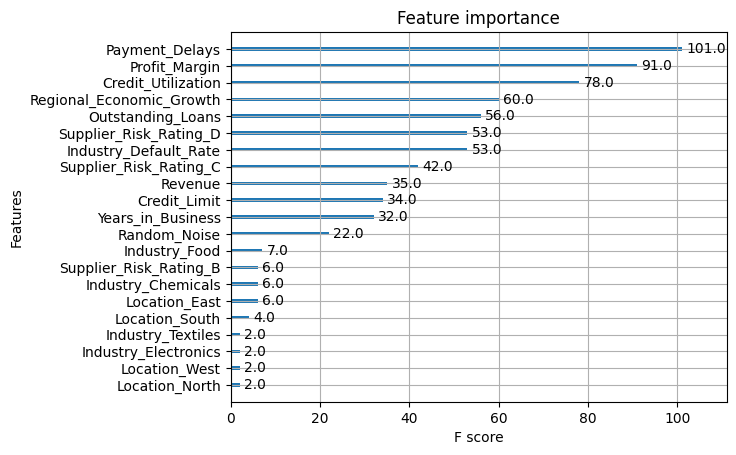

In [42]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

model = models["XGBoost"]
plot_importance(model)
plt.show()

In [43]:
import joblib

# Save the trained model
joblib.dump(model, "supplier_default_model.pkl")
print("Model saved as supplier_default_model.pkl")

Model saved as supplier_default_model.pkl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.4 MB/s eta 0:00:00


In [44]:
!ngrok authtoken 2qJIYcClSzqyb0Pwq6dn2BccixK_5X3i3fBj5Q8ULu33TqwDv

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [45]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd

# Initialize FastAPI
app = FastAPI()

# Define the input schema
class SupplierDataInput(BaseModel):
    Credit_Utilization: float
    Payment_Delays: int
    Profit_Margin: float
    Revenue: float
    Outstanding_Loans: float
    Years_in_Business: int
    Supplier_Risk_Rating: str
    Industry_Default_Rate: float
    Regional_Economic_Growth: float
    Location: str
    Industry: str

# Load the trained model and features
model = joblib.load("supplier_default_model.pkl")

# Save the feature columns used in training
feature_columns = [
    "Years_in_Business", "Revenue", "Profit_Margin", "Outstanding_Loans",
    "Credit_Limit", "Credit_Utilization", "Payment_Delays",
    "Industry_Default_Rate", "Regional_Economic_Growth",
    "Location_East", "Location_North", "Location_South", "Location_West",
    "Industry_Chemicals", "Industry_Electronics", "Industry_Food", "Industry_Textiles",
    "Supplier_Risk_Rating_B", "Supplier_Risk_Rating_C", "Supplier_Risk_Rating_D",
    "Random_Noise"
]

# Define one-hot encoding mappings
location_categories = ["East", "North", "South", "West"]
industry_categories = ["Chemicals", "Electronics", "Food", "Textiles"]
risk_rating_categories = ["B", "C", "D"]

@app.post("/predict")
def predict_default(data: SupplierDataInput):
    try:
        # Convert input to DataFrame
        input_data = pd.DataFrame([data.dict()])

        # One-hot encode categorical features
        for category in location_categories:
            input_data[f"Location_{category}"] = (input_data["Location"] == category).astype(int)

        for category in industry_categories:
            input_data[f"Industry_{category}"] = (input_data["Industry"] == category).astype(int)

        for category in risk_rating_categories:
            input_data[f"Supplier_Risk_Rating_{category}"] = (input_data["Supplier_Risk_Rating"] == category).astype(int)

        # Drop original categorical columns
        input_data = input_data.drop(columns=["Location", "Industry", "Supplier_Risk_Rating"])

        # Add missing columns with default value 0 (to match training data)
        for col in feature_columns:
            if col not in input_data.columns:
                input_data[col] = 0

        # Ensure the columns are in the same order as the training data
        input_data = input_data[feature_columns]

        # Make prediction
        prediction_proba = model.predict_proba(input_data)[:, 1]
        prediction_class = model.predict(input_data)

        return {
            "default_probability": float(prediction_proba[0]),
            "default_prediction": int(prediction_class[0])
        }
    except Exception as e:
        return {"error": str(e)}




In [ ]:
import nest_asyncio
import uvicorn
from pyngrok import ngrok

# Apply the asyncio patch
nest_asyncio.apply()

# Create a public URL with ngrok
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

# Run the Uvicorn server
uvicorn.run(app, host="0.0.0.0", port=8000)


Public URL: NgrokTunnel: "https://0cb6-35-247-62-39.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [185]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])


INFO:     223.185.135.213:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-45-4ed2349ba31e>:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  input_data = pd.DataFrame([data.dict()])
